# Challenge
<br>The main target is to develop a prediction model accurate enough for predicting the weather. We can try something like predicting the weather in the next 24 hours like microsoft tried some time back.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [12]:
data = pd.read_csv('testset.csv', parse_dates = ['datetime_utc'],dayfirst = False)

In [13]:
data.head()

datetime_utc  _conds   _dewptm   _fog   _hail   _heatindexm   _hum  \
0 1996-11-01 11:00:00   Smoke       9.0      0       0           NaN   27.0   
1 1996-11-01 12:00:00   Smoke      10.0      0       0           NaN   32.0   
2 1996-11-01 13:00:00   Smoke      11.0      0       0           NaN   44.0   
3 1996-11-01 14:00:00   Smoke      10.0      0       0           NaN   41.0   
4 1996-11-01 16:00:00   Smoke      11.0      0       0           NaN   47.0   

    _precipm   _pressurem   _rain   _snow   _tempm   _thunder   _tornado  \
0        NaN       1010.0       0       0     30.0          0          0   
1        NaN      -9999.0       0       0     28.0          0          0   
2        NaN      -9999.0       0       0     24.0          0          0   
3        NaN       1010.0       0       0     24.0          0          0   
4        NaN       1011.0       0       0     23.0          0          0   

    _vism   _wdird  _wdire   _wgustm   _windchillm   _wspdm  
0     5.0    280.0    West       NaN           NaN      7.4  
1     NaN      0.0   North       NaN           NaN      NaN  
2     NaN      0.0   North       NaN           NaN      NaN  
3     2.0      0.0   North       NaN           NaN      NaN  
4     1.2      0.0   North       NaN           NaN      0.0

# Data Preprocessing

## Chronological order and equidistant timestamps

The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data.

But, first of all, lets see how to check if our dataset is correctly formated!

In [19]:
# Setting the data in chronological order
data = data.sort_values(by = 'datetime_utc')

# Checking equidistant timestamps
data['delta'] = data['datetime_utc'] - data['datetime_utc'].shift(1)

data[['datetime_utc','delta']].head(10)
# timestamps are not equidistant
# will be resampling the data to have a constant timestamp of 24 hours/1 day
#Hence, we would be downsampling the data

datetime_utc           delta
0 1996-11-01 11:00:00             NaT
1 1996-11-01 12:00:00 0 days 01:00:00
2 1996-11-01 13:00:00 0 days 01:00:00
3 1996-11-01 14:00:00 0 days 01:00:00
4 1996-11-01 16:00:00 0 days 02:00:00
5 1996-11-01 17:00:00 0 days 01:00:00
6 1996-11-01 18:00:00 0 days 01:00:00
7 1996-11-01 19:00:00 0 days 01:00:00
8 1996-11-01 20:00:00 0 days 01:00:00
9 1996-11-01 21:00:00 0 days 01:00:00

In [21]:
data.columns

Index(['datetime_utc', ' _conds', ' _dewptm', ' _fog', ' _hail',
       ' _heatindexm', ' _hum', ' _precipm', ' _pressurem', ' _rain', ' _snow',
       ' _tempm', ' _thunder', ' _tornado', ' _vism', ' _wdird', ' _wdire',
       ' _wgustm', ' _windchillm', ' _wspdm', 'delta'],
      dtype='object')

### Downsampling the data

In [22]:
# downsampling the data
resampled = data[['datetime_utc', ' _conds', ' _dewptm', ' _fog', ' _hail',
       ' _heatindexm', ' _hum', ' _precipm', ' _pressurem', ' _rain', ' _snow',
       ' _tempm', ' _thunder', ' _tornado', ' _vism', ' _wdird', ' _wdire',
       ' _wgustm', ' _windchillm', ' _wspdm']].resample('D', on = 'datetime_utc').mean().reset_index(drop = False)

In [23]:
# checking equidistant timestamp
resampled['delta'] = resampled['datetime_utc'] - resampled['datetime_utc'].shift(1)

resampled[['datetime_utc','delta']]

datetime_utc  delta
0      1996-11-01    NaT
1      1996-11-02 1 days
2      1996-11-03 1 days
3      1996-11-04 1 days
4      1996-11-05 1 days
...           ...    ...
7475   2017-04-20 1 days
7476   2017-04-21 1 days
7477   2017-04-22 1 days
7478   2017-04-23 1 days
7479   2017-04-24 1 days

[7480 rows x 2 columns]

## Missing values

In [25]:
(resampled.isna().sum()/len(resampled))*100

datetime_utc      0.000000
 _dewptm          1.925134
 _fog             1.885027
 _hail            1.885027
 _heatindexm     75.334225
 _hum             1.925134
 _precipm       100.000000
 _pressurem       1.885027
 _rain            1.885027
 _snow            1.885027
 _tempm           1.925134
 _thunder         1.885027
 _tornado         1.885027
 _vism            1.925134
 _wdird           3.342246
 _wgustm         95.254011
 _windchillm     97.593583
 _wspdm           1.925134
delta             0.013369
dtype: float64

In [32]:
# Removing columns having more than 70% missing values
# for the rest, will try out different imputation methods
resampled.drop(columns = [' _precipm',' _heatindexm',' _wgustm',' _windchillm'],axis=1,inplace = True)

resampled.columns


Index(['datetime_utc', ' _dewptm', ' _fog', ' _hail', ' _hum', ' _pressurem',
       ' _rain', ' _snow', ' _tempm', ' _thunder', ' _tornado', ' _vism',
       ' _wdird', ' _wspdm', 'delta'],
      dtype='object')

### Creating a function to visualise the effect of different missing value treatment methods on the data
- The input must be a single series 
- Try the various options<br>
> Option 1: Fill missing values with zero<br>
> Option 2: Fill missing values with mean<br>
> Option 3: Fill missing values with the next/last value (ffill/bfill)<br>
> Option 4: Fill missing values with Linearly interpolated value<br>
- Visualise the effect of various options on the original data using seaborn plots
- Use dark orange colour code for the treatment options and dodger blue code for the original data

In [34]:
# Creating function

In [63]:
def missing_values_visualisation(series,method='zero'):
    #define figure size
    sns.set(rc={"figure.figsize":(8, 4)}) #width=8, height=4
    if method == 'zero':
        sns.lineplot(x= resampled.datetime_utc, y = resampled[series].fillna(0),color = 'dodgerblue', label = 'original').set(title = 'Missing values treatment with imputation(0)')
        sns.lineplot(x = resampled.datetime_utc, y = resampled[series].fillna(np.inf) ,color = 'darkorange', label = 'modified')
    
    if method == 'mean':
        sns.lineplot(x= resampled.datetime_utc, y = resampled[series].fillna(resampled.series.mean()),color = 'dodgerblue', label = 'original').set(title = f'Missing values treatment with imputation(mean) ({resampled.series.mean():.0f})')
        sns.lineplot(x = resampled.datetime_utc, y = resampled[series].fillna(np.inf) ,color = 'darkorange', label = 'modified')
      
    if method == 'bfill':
        sns.lineplot(x= resampled.datetime_utc, y = resampled[series].ffill(),color = 'dodgerblue', label = 'original').set(title = 'Missing values treatment with the last value')
        sns.lineplot(x = resampled.datetime_utc, y = resampled[series].fillna(np.inf) ,color = 'darkorange', label = 'modified')

    if method == 'ffill':
        sns.lineplot(x= resampled.datetime_utc, y = resampled[series].bfill,color = 'dodgerblue', label = 'original').set(title = 'Missing values treatment with next value')
        sns.lineplot(x = resampled.datetime_utc, y = resampled[series].fillna(np.inf) ,color = 'darkorange', label = 'modified')
        
    if method == 'interpolate':
        sns.lineplot(x= resampled.datetime_utc, y = resampled[series].interpolate(),color = 'dodgerblue', label = 'original').set(title = 'Missing values treatment with linear interpolation')
        sns.lineplot(x = resampled.datetime_utc, y = resampled[series].fillna(np.inf) ,color = 'darkorange', label = 'modified')
        
    if method == 'all':
        f, ax = plt.subplots(nrows=4, ncols=1, figsize=(18, 12))

        sns.lineplot(x=resampled.datetime_utc, y=resampled[series].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
        sns.lineplot(x=resampled.datetime_utc, y=resampled[series].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
        ax[0].set_title('Missing values treatment with imputation(0)', fontsize=14)

        mean_val = resampled[series].mean()
        sns.lineplot(x=resampled.datetime_utc, y=resampled[series].fillna(mean_val), ax=ax[1], color='darkorange', label = 'modified')
        sns.lineplot(x=resampled.datetime_utc, y=resampled[series].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
        ax[1].set_title(f'Missing values treatment with imputation(mean) ({mean_val:.0f})', fontsize=14)
        

        sns.lineplot(x=resampled.datetime_utc, y=resampled[series].ffill(), ax=ax[2], color='darkorange', label = 'modified ffill')
        sns.lineplot(x=resampled.datetime_utc, y=resampled[series].bfill(), ax=ax[2], color='forestgreen', label = 'modified bfill')
        sns.lineplot(x=resampled.datetime_utc, y=resampled[series].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
        ax[2].set_title(f'Missing values treatment with the last value/next value', fontsize=14)

        sns.lineplot(x=resampled.datetime_utc, y=resampled[series].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
        sns.lineplot(x=resampled.datetime_utc, y=resampled[series].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
        ax[3].set_title(f'Interpolate', fontsize=14)
        
        #sns.lineplot(x=resampled.datetime_utc, y=resampled[series].bfill(), ax=ax[2], color='darkorange', label = 'modified')
        #sns.lineplot(x=resampled.datetime_utc, y=resampled[series].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
        #ax[4].set_title(f'Missing values treatment with the next value', fontsize=14)
# not including the constraint bfill and ffill together since the visualisations overlap each other
    plt.tight_layout()    
    plt.show()    

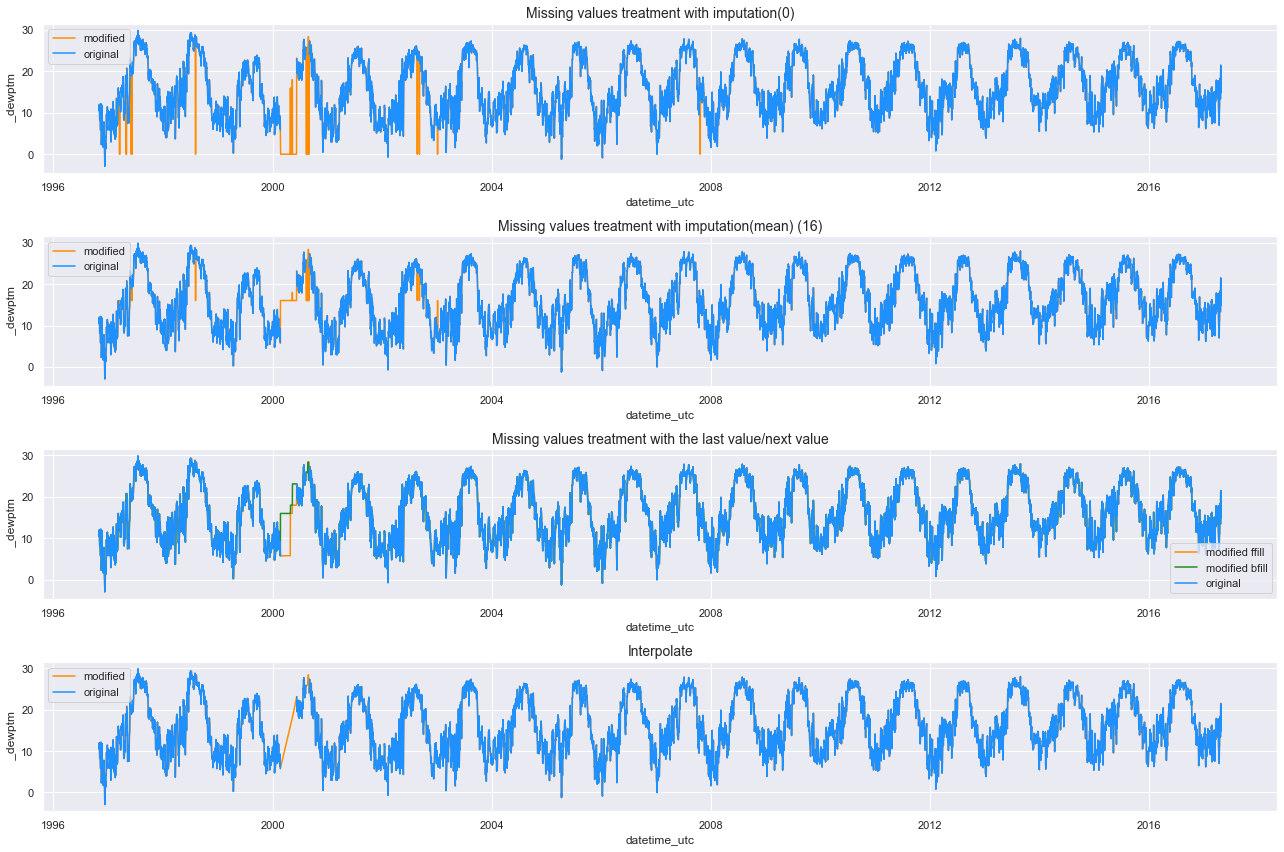

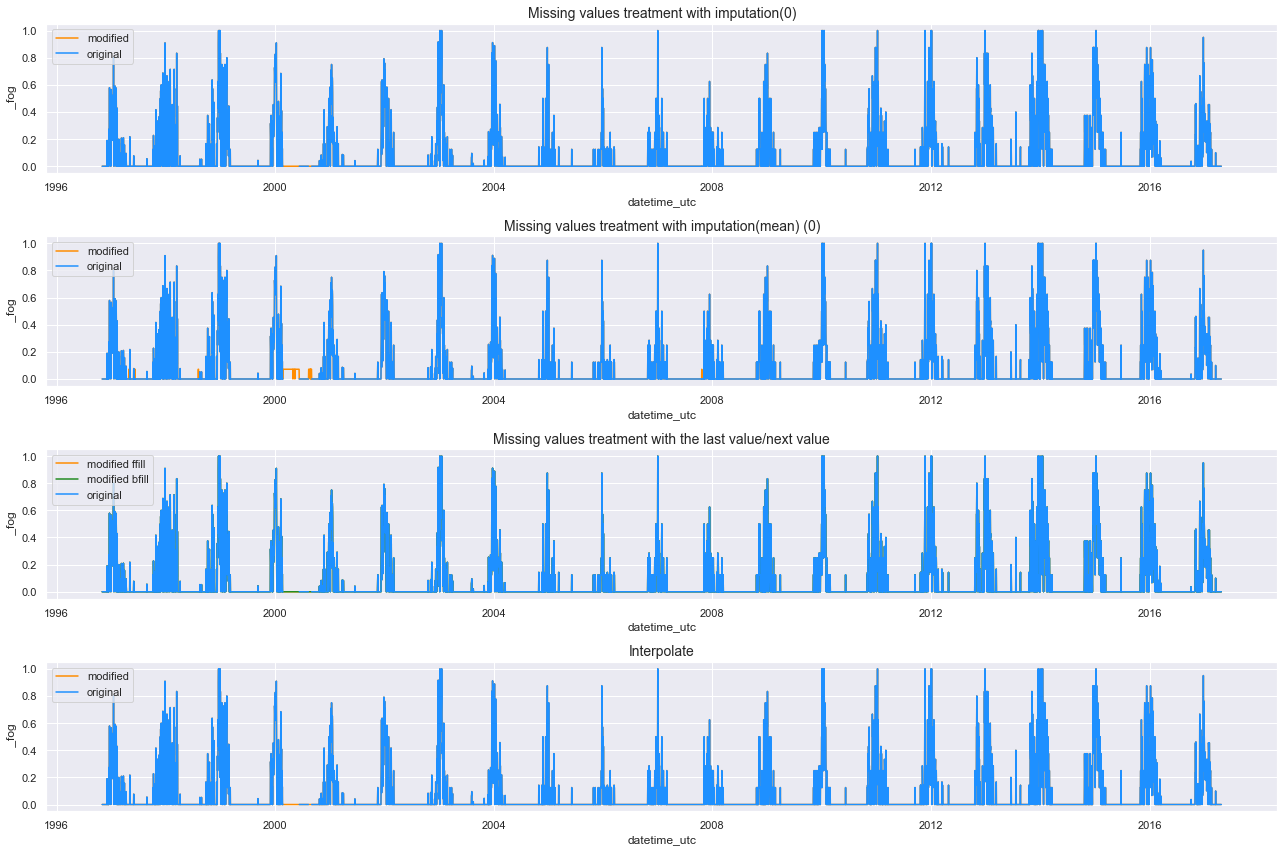

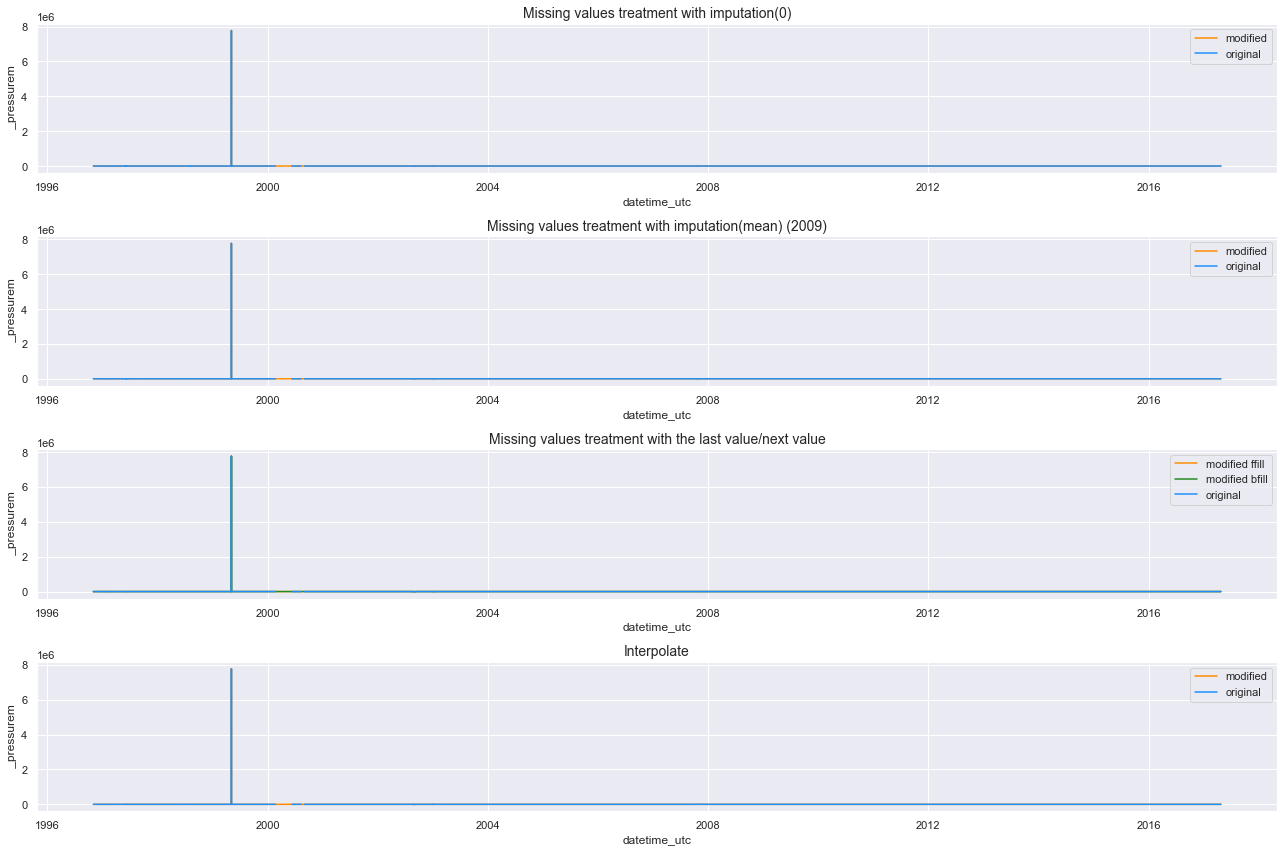

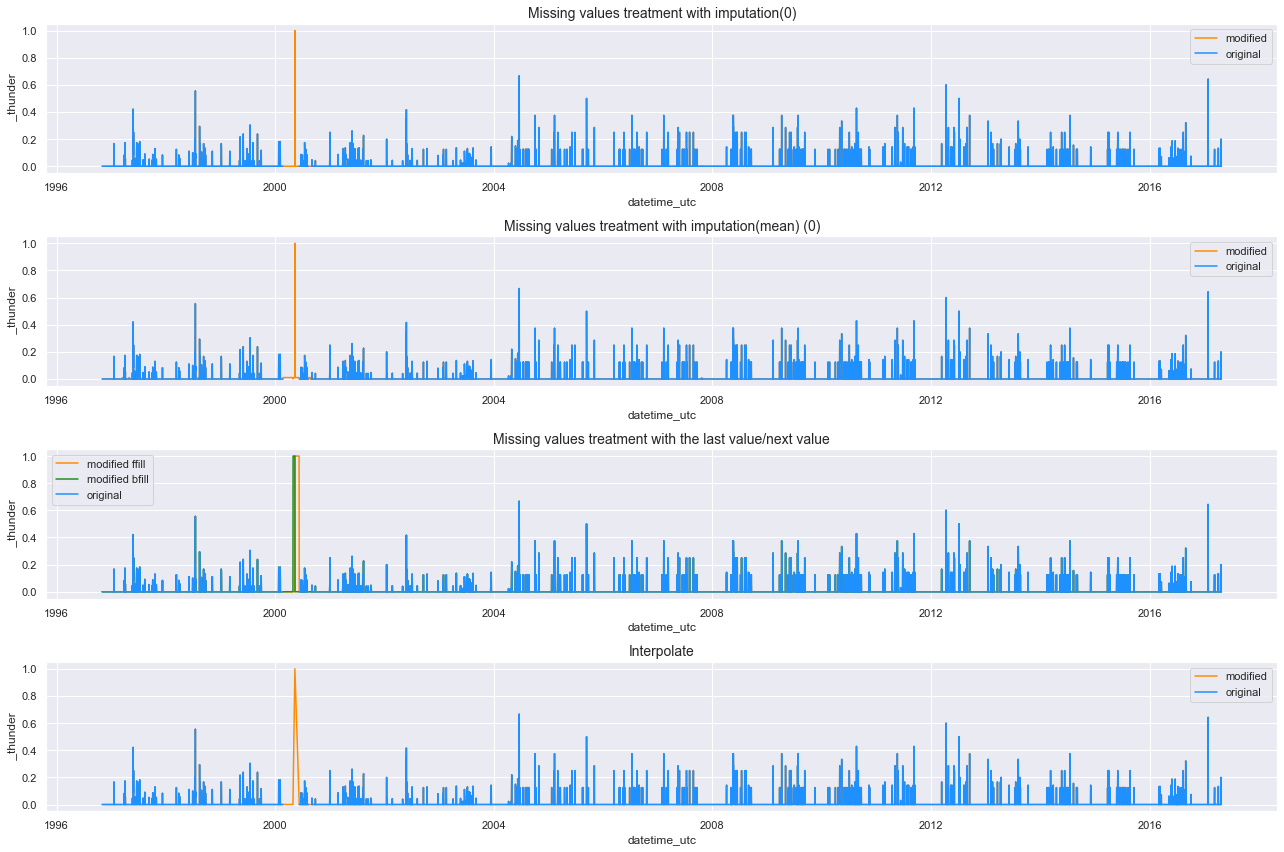

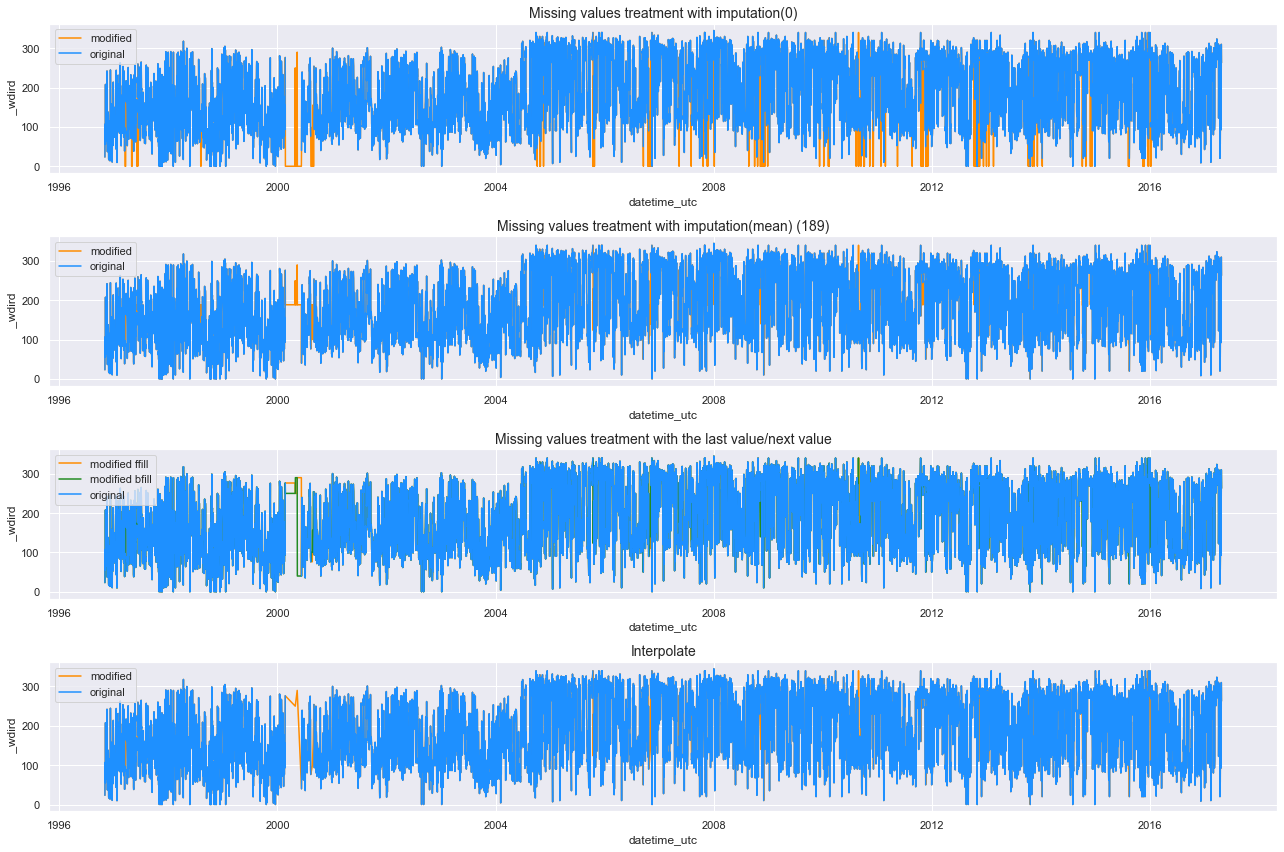

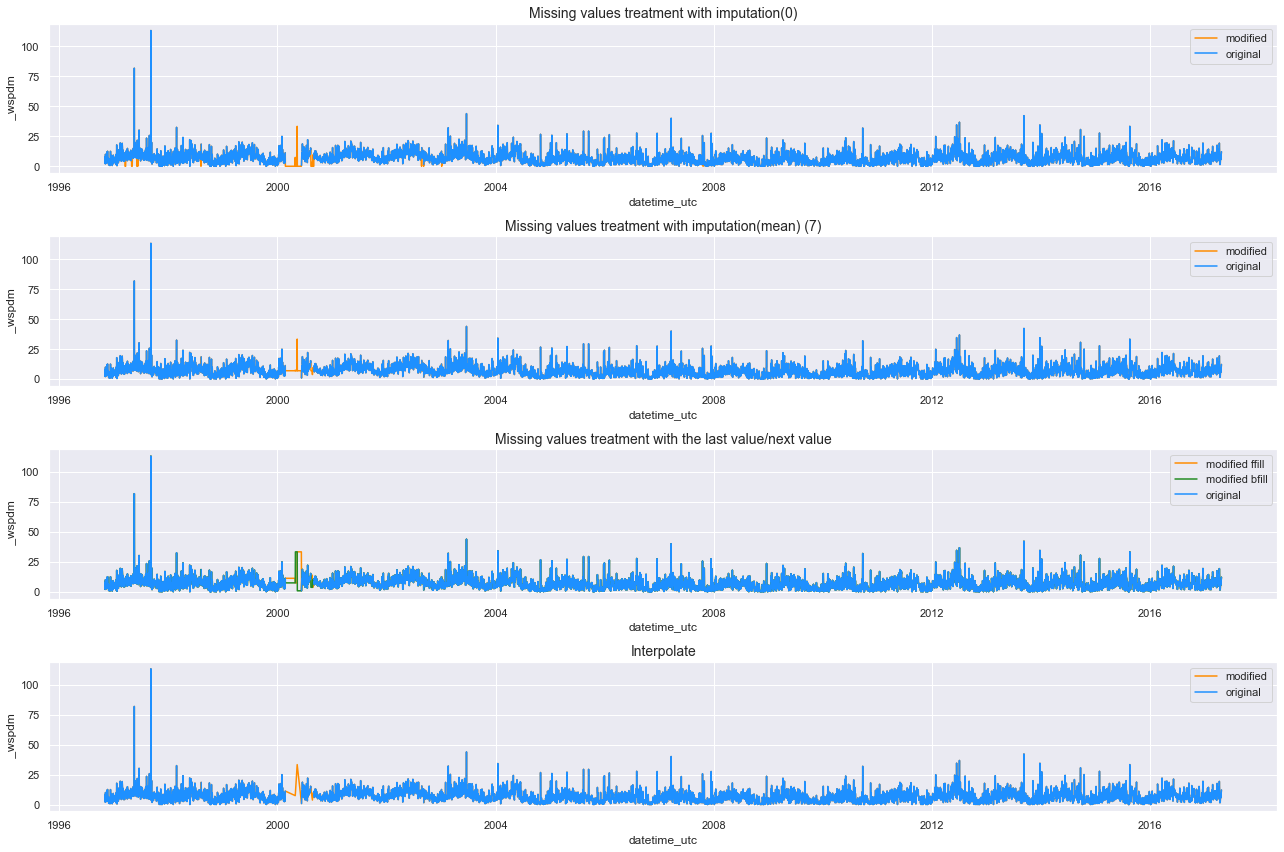

In [88]:
# Trying to run the function missing values visualisation on all the columns of the resampled
# data excluding date time and delta columns
columns = [' _dewptm', ' _fog', ' _hail', ' _hum', ' _pressurem',
       ' _rain', ' _snow', ' _thunder', ' _tornado', ' _vism',
       ' _wdird', ' _wspdm']
for i in range(0,len(columns)):
    missing_values_visualisation(columns[i],method = 'all')

The graph for ' _dewptm' is more or less better represented when imputing the missing values with interpolation. Moreover, bfill also seems like a viable option to represent the missing values by imputing the values with the next value in the series.
  

The graph for ' _fog' is more or less better represented when imputing the missing values with bfill,ffill and interpolation. Also,  it coincides with the visual representation when imputing the missing values with zero. Hence, we can use any of the above choices.

<div class="alert alert-block alert-info">
<b>Note:</b>' _dewptm' --> interpolate/bfill
    <br>' _fog' --> bfill/ffill, interpolate
    <br>' _hail' --> zero, mean, bfill/ffill, interpolate
    <br>' _hum' -->interpolation
    <br>' _pressurem' -->interpolation, bfill/ffill
    <br>' _rain' --> bfill, interpolation
    <br>' _snow' --> all methods
    <br>' _thunder' --> interpolation
    <br>' _tornado' --> all methods
    <br>' _vism' --> bfill, interpolation
    <br>' _wspdm' --> interpolation
</div>

In [99]:
# Treating missing values with linear interpolation
for i in columns:
    resampled[i].interpolate(method='linear',axis=0, inplace = True)

## Stationarity

In the most intuitive sense, **stationarity** means that the **statistical properties** of a process generating a time series **do not change over time**. It does not mean that the series does not change over time, just that the way it changes does not itself change over time.

Stationarity describes that the time-series has
* constant mean and mean is not time-dependent 
* constant variance and variance is not time-dependent 
* constant covariance and covariance is not time-dependent 

<div class='alert alert-block alert-info'>
     <b> Note: </b>If a time series has a specific (stationary) behavior over a given time interval, then it can be assumed that the time series will behave the same at a later time.
</div>

Time series **with trend and/or seasonality are not stationary**. Trend indicates that the mean is not constant over time and seasonality indicates that the variance is not constant over time.

The check for stationarity can be done via three different approaches:
1. **visually**: plot time series and check for trends or seasonality
2. **basic statistics**: split time series and compare the mean and variance of each partition
3. **statistical test**: Unit root test (Dickey-Fuller Test, Zivot and Andrews Test, KPSS test), Semi-parametric test (Variance Ratio Test) __[Tests for stationarity](https://www.kdnuggets.com/2019/08/stationarity-time-series-data.html)__

### Visual Check for stationarity

In [110]:
# creating a function to visualise the stationarity
def visualise_stationarity(series,window):
    sns.set(rc={'figure.figsize':(14,8)})
    sns.lineplot(x =resampled.datetime_utc ,y= series,color = 'indianred')
    sns.lineplot(x =resampled.datetime_utc ,y= series.rolling(window).mean(),color = 'black', label = 'Rolling mean')
    sns.lineplot(x =resampled.datetime_utc ,y= series.rolling(window).std(),color = 'blue', label = 'Rolling std')
    plt.show()

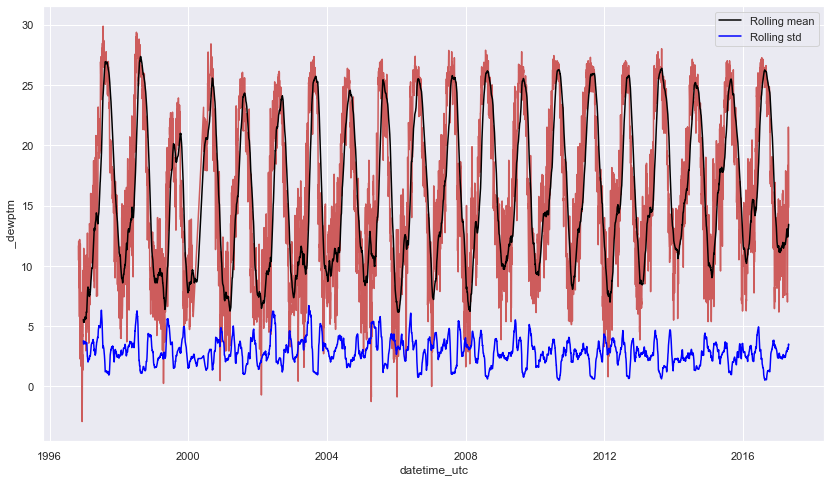

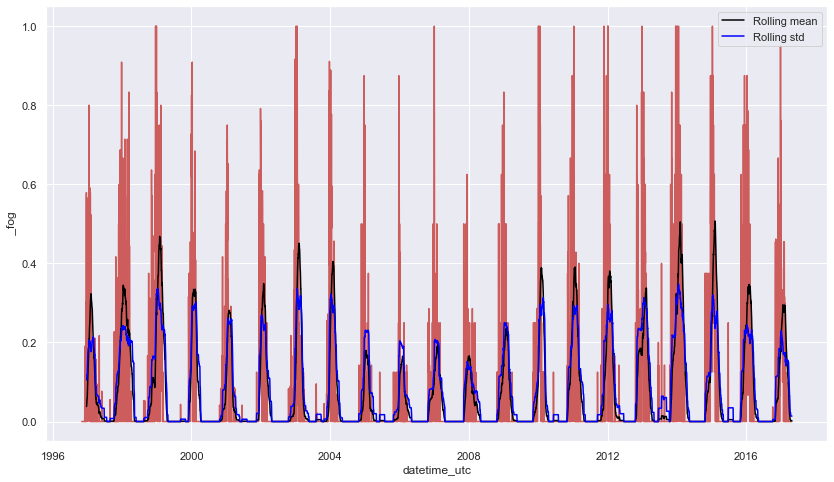

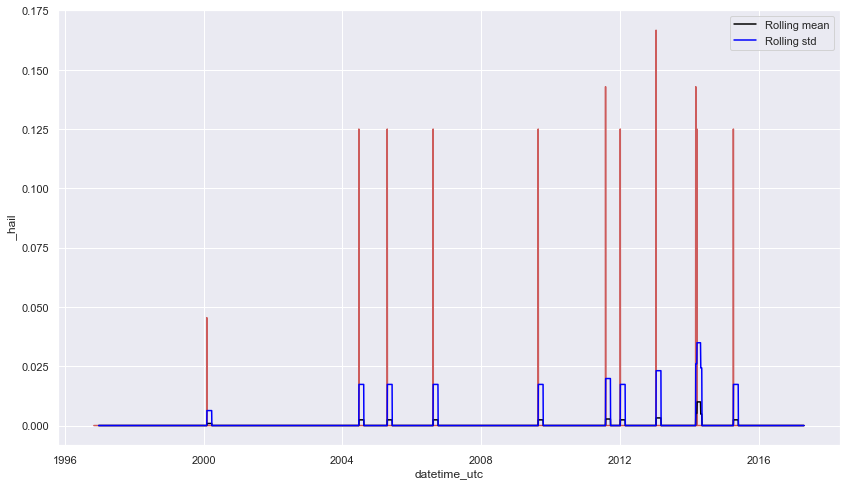

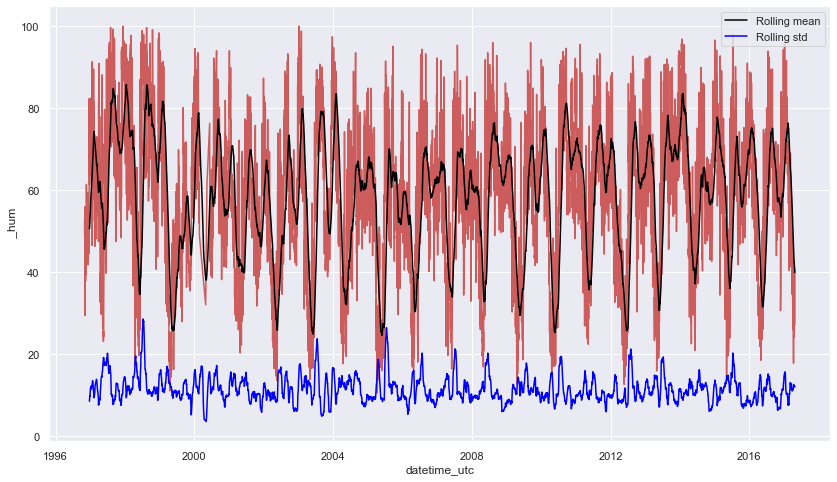

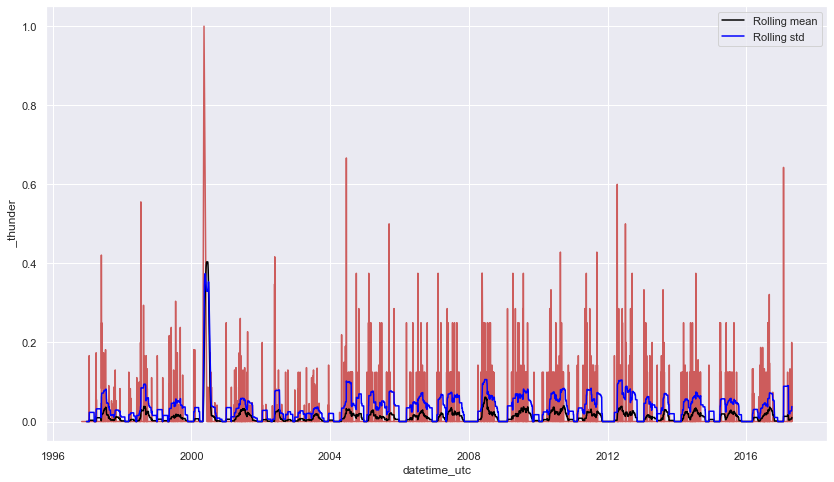

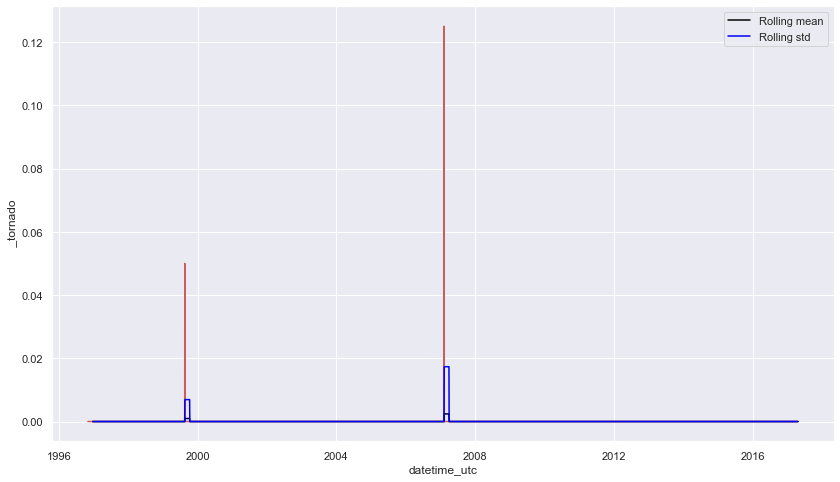

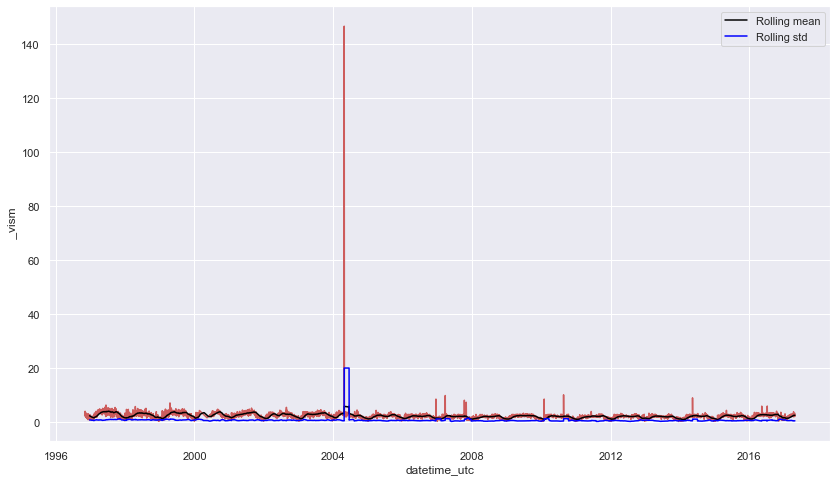

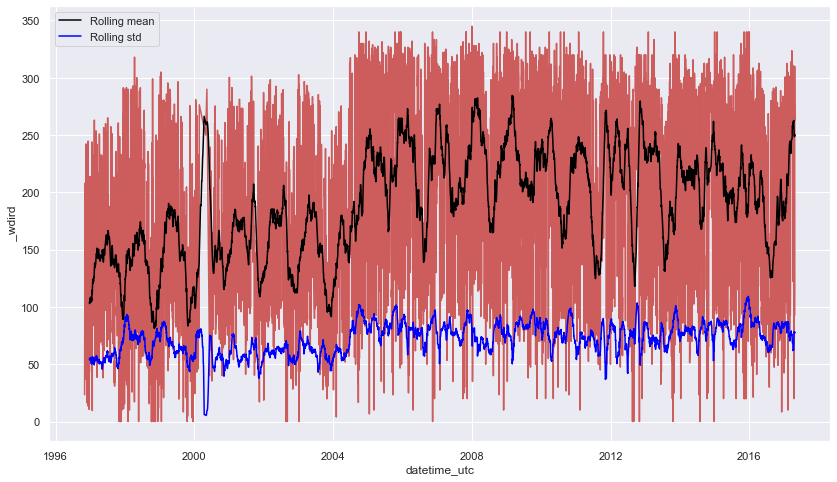

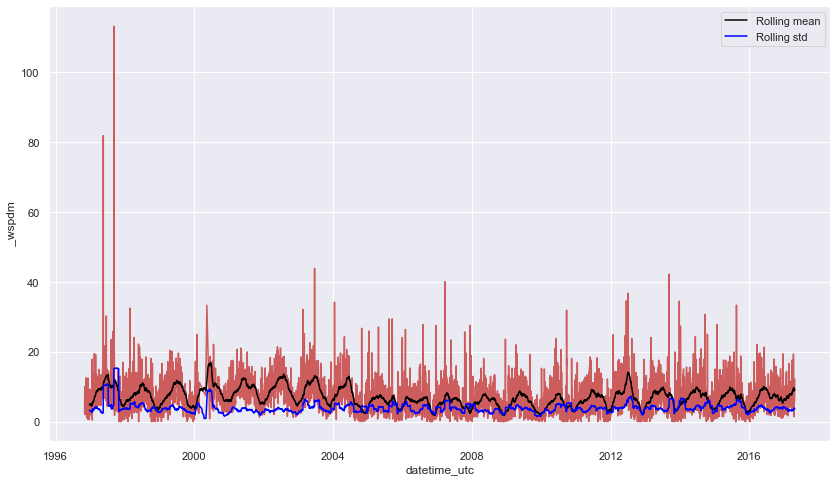

In [111]:
columns = [' _dewptm', ' _fog', ' _hail', ' _hum', ' _pressurem',
       ' _rain', ' _snow', ' _tempm', ' _thunder', ' _tornado', ' _vism',
       ' _wdird', ' _wspdm']
for i in columns:
    visualise_stationarity(resampled[i],52)

### Basic statistics

Next, we will **check the underlying statistics**. For this we will **split the time series into two sections** and check the mean and the variance. You could do more partitions if you wanted.

In [118]:
df= resampled[columns]

In [119]:
num_partitions = 2
partition_length = int(len(resampled)/num_partitions)

partition1_mean = df.head(partition_length).mean()
partition1_var = df.head(partition_length).var()
partition2_mean = df.tail(partition_length).mean()
partition2_var = df.tail(partition_length).var()

In [120]:
stationarity_test = pd.concat([partition1_mean, partition2_mean, partition1_var, partition2_var], axis=1)
stationarity_test.columns = ['Partition 1 Mean', 'Partition 2 Mean', 'Partition 1 Variance', 'Partition 2 Variance']
def highlight_greater(x):
    temp = x.copy()
    temp = temp.round(0).astype(int)
    m1 = (temp['Partition 1 Mean'] == temp['Partition 2 Mean'])
    m2 = (temp['Partition 1 Variance'] == temp['Partition 2 Variance'])
    m3 = (temp['Partition 1 Mean'] < temp['Partition 2 Mean']+3) & (temp['Partition 1 Mean'] > temp['Partition 2 Mean']-3)
    m4 = (temp['Partition 1 Variance'] < temp['Partition 2 Variance']+3) & (temp['Partition 1 Variance'] > temp['Partition 2 Variance']-3)

    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    df1['Partition 1 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Mean'])

    df1['Partition 1 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Variance'])

    return df1

stationarity_test.style.apply(highlight_greater, axis=None).format("{:20,.0f}")

<div class="alert alert-block alert-info">
    <b>Note: </b><br>
    ' _dewptm' --> non constant mean, non-constant variance<br>
' _fog' -->  constant mean, constant variance<br>
' _hail' -->  constant mean, constant variance *<br>
' _hum' --> non constant mean, non-constant variance<br>
' _pressurem' --> non constant mean, non-constant variance**<br>
' _rain' -->  constant mean, constant variance <br>
' _snow' -->  constant mean, constant variance** <br>
' _tempm' -->  constant mean, non-constant variance <br>
' _thunder' -->  constant mean, constant variance** <br>
' _tornado' -->  constant mean, constant variance** <br>
' _vism' --> constant mean, non-constant variance *<br>
' _wdird' --> non constant mean, non-constant variance <br>
' _wspdm' -->non constant mean, non-constant variance
</div>

<a id='2.3.1'></a>
### Unit Root Test

Unit root is a characteristic of a time series that makes it non-stationary. And ADF test belong to the unit root test. Technically , a unit root is said to exist in a time series of value of alpha =1 in below equation.

$Y_t = 	\alpha Y_{t-1} + 	\beta X_{e} + \epsilon $

where Yt is value of the time series at time ‘t’ and Xe is an exogenous variable .

**The presence of a unit root means the time series is non-stationary.**

### Augmented Dickey-Fuller (ADF)</p>


**Augmented Dickey-Fuller (ADF)** test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

* **Null Hypothesis (H0)**: Time series has a unit root. (Time series is not stationary).

* **Alternate Hypothesis (H1)**: Time series has no unit root (Time series is stationary).

**If the null hypothesis can be rejected, we can conclude that the time series is stationary.**

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

* <font color='red'>**p-value > significance level (default: 0.05)**</font>: Fail to reject the null hypothesis (H0), the data has a unit root and is <font color='red'>non-stationary</font>.
* <font color='green'>**p-value <= significance level (default: 0.05)**</font>: Reject the null hypothesis (H0), the data does not have a unit root and is <font color='green'>stationary</font>.
    
On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.
* <font color='red'>**ADF statistic > critical value**</font>: Fail to reject the null hypothesis (H0), the data has a unit root and is <font color='red'>non-stationary</font>.
* <font color='green'>**ADF statistic < critical value**</font>: Reject the null hypothesis (H0), the data does not have a unit root and is <font color='green'>stationary</font>.

In [ ]:
' _dewptm', ' _fog', ' _hail', ' _hum', ' _pressurem',
       ' _rain', ' _snow', ' _tempm', ' _thunder', ' _tornado', ' _vism',
       ' _wdird', ' _wspdm'

In [122]:
# importing the appropriate library
from statsmodels.tsa.stattools import adfuller

result = adfuller(resampled[' _dewptm'].values)
result

(-6.131925625979657,
 8.361758324536683e-08,
 31,
 7448,
 {'1%': -3.4312282968839054,
  '5%': -2.861928140332513,
  '10%': -2.5669766027320393},
 28649.31542083384)

Now, we are going to check for each variable:
* The p-value is less than 0.05
* Check the range of the ADF statistic compared with critical_values 
* Visualise the result of adfuller test

In [143]:
def adf_results(series):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    critical_val1 = result[4]['1%']
    critical_val5 = result[4]['5%']
    critical_val10 = result[4]['10%']
    return (p_val,significance_level,adf_stat,critical_val1,critical_val5,critical_val10)


In [144]:
def visualise_adf(series,title):
    p_val,significance_level,adf_stat,critical_val1,critical_val5,critical_val10 = adf_results(series)
    
    if((p_val < significance_level) & (adf_stat<critical_val1)):
        linecolor = 'forestgreen'
    elif((p_val < siginificance_level) & (adf_stat < critical_val5)):
        linecolor = 'gold'
    elif((p_val < significance_level) & (adf_stat < critical_val10)):
        linecolor = 'orange'
    else:
        linecolor = 'purple'    

    ax = sns.lineplot(x = resampled.datetime_utc, y = series, color = linecolor)
    ax.set(ylabel = title,
          title= f'ADF Statistic {adf_stat:0.3f}, p-value {p_val: 0.3f}\n Critical values 1% {critical_val1: 0.3f}\n Critical values 5% {critical_val5:0.3f}\n Critical values 10% {critical_val10:0.3f}',
          )
    plt.show()

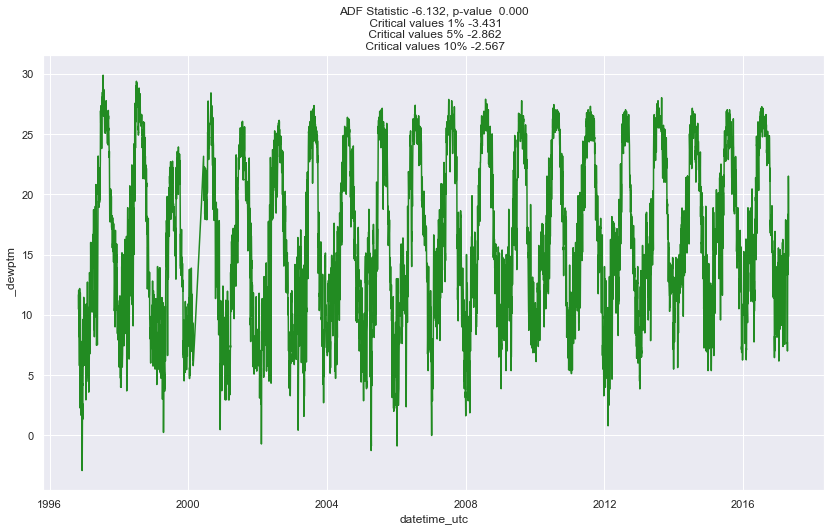

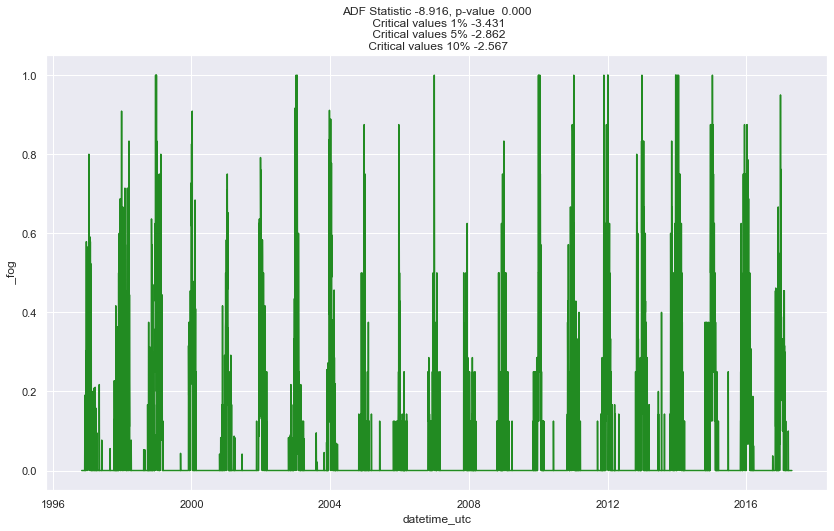

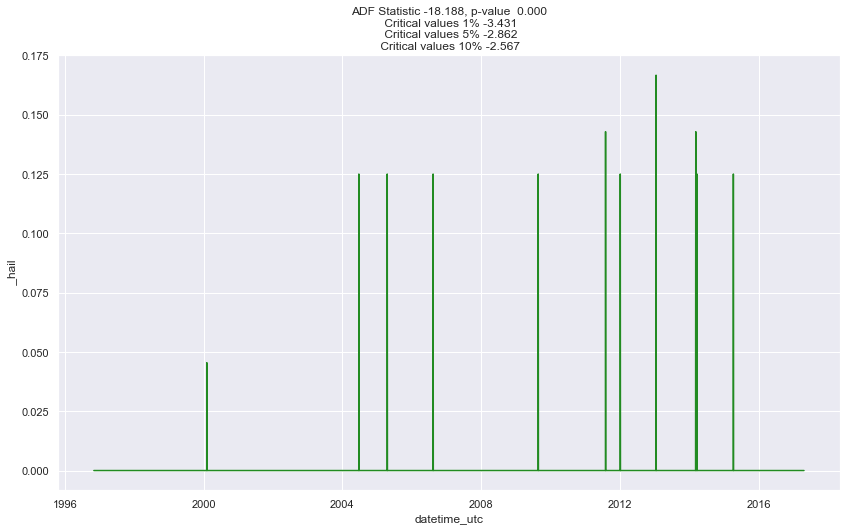

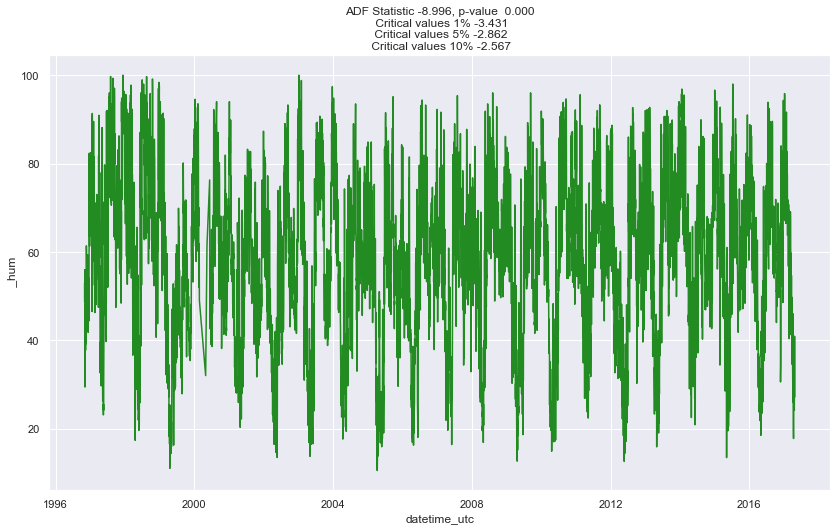

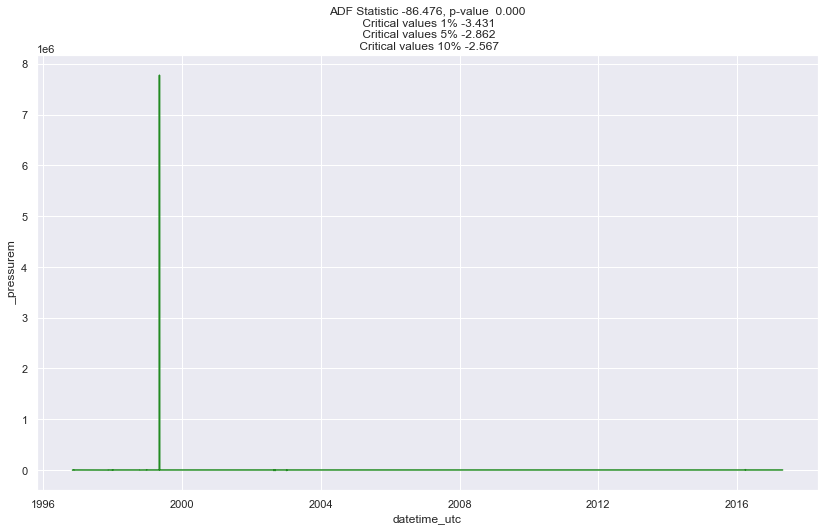

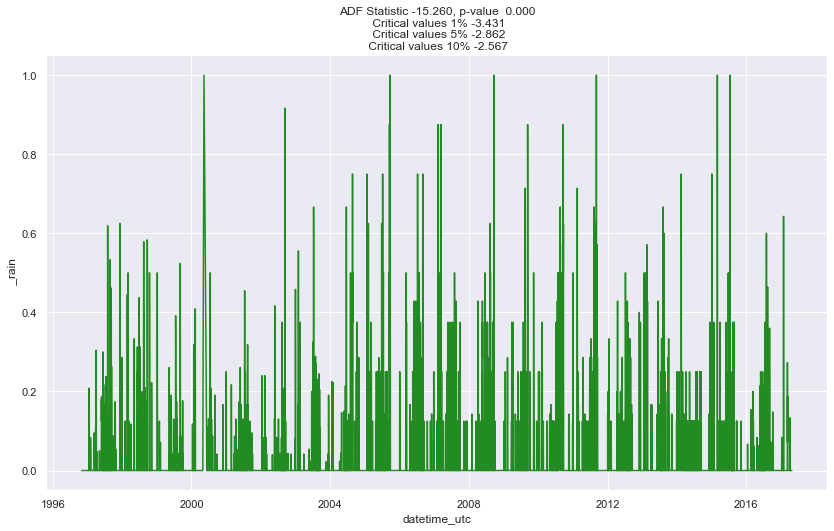

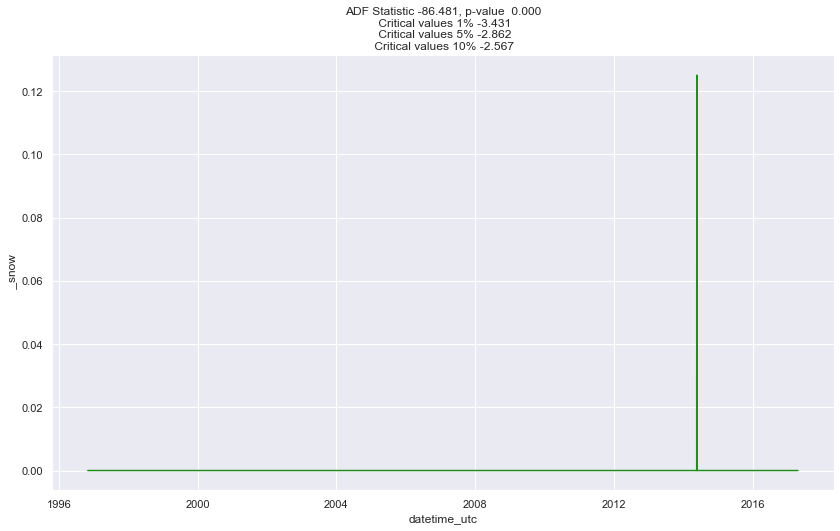

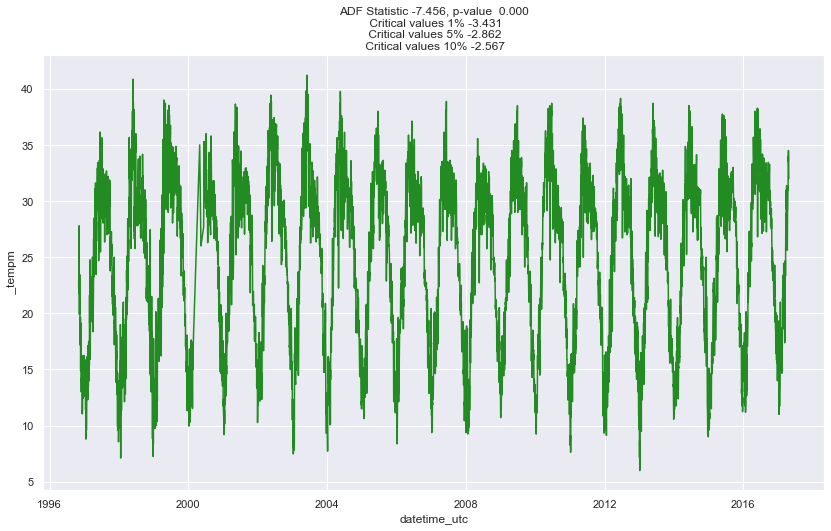

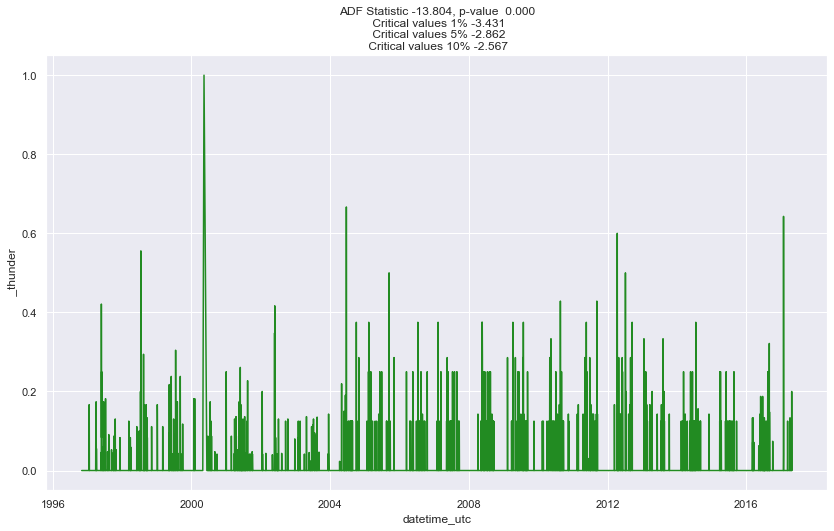

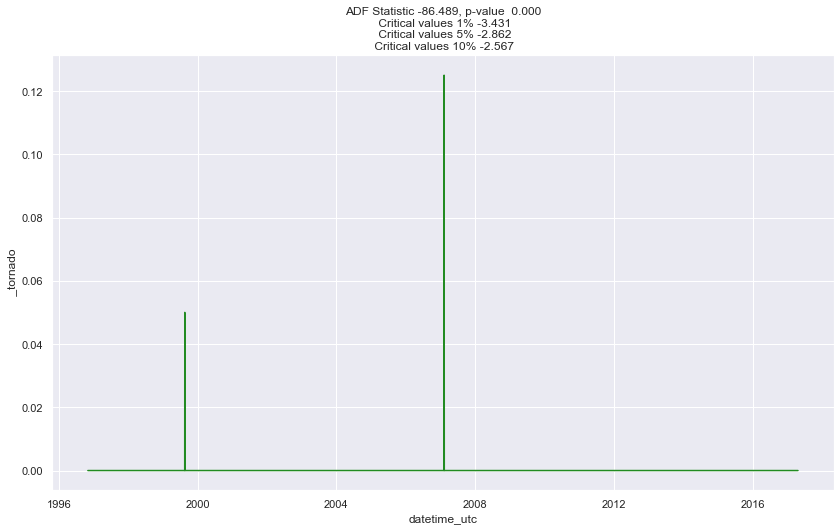

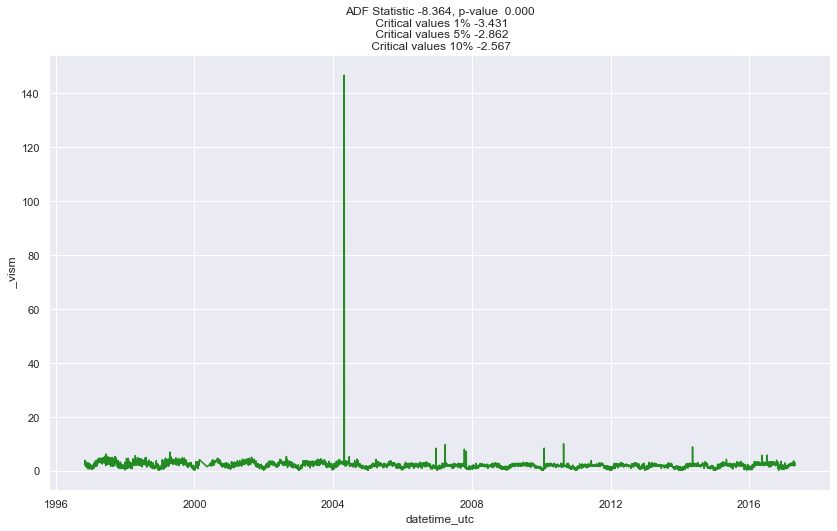

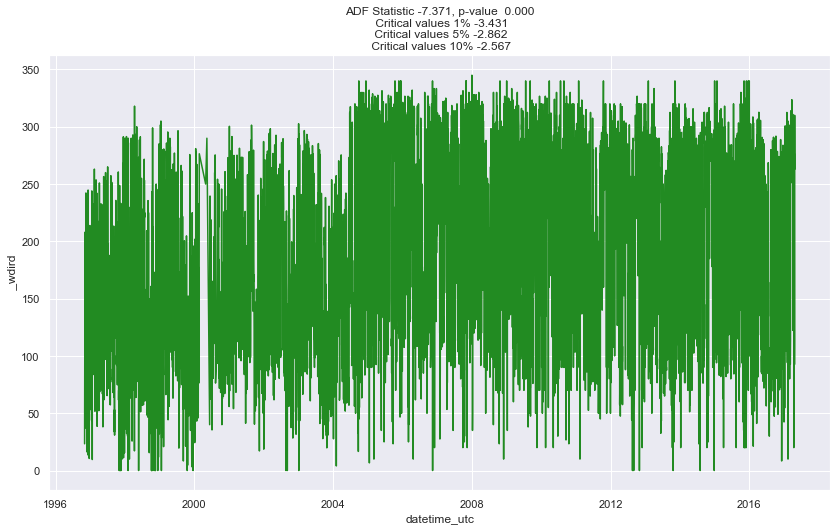

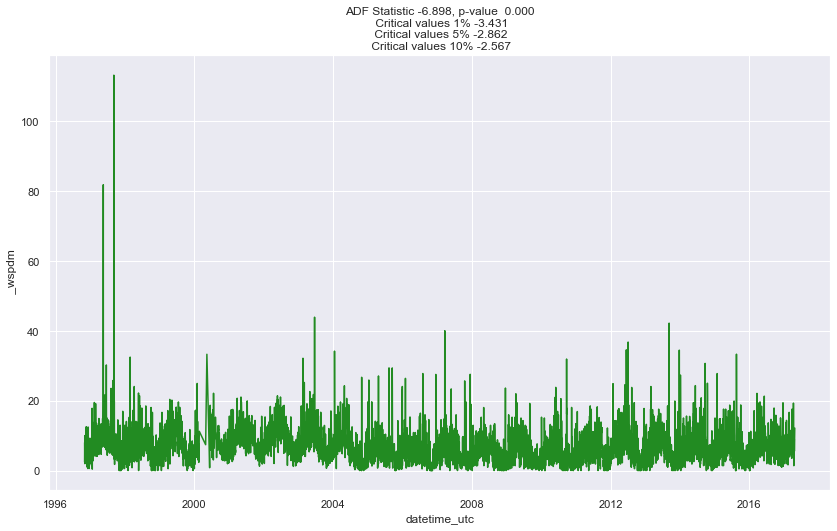

In [145]:
for i in columns:
    visualise_adf(resampled[i],i)

**ADFULLER Test Results**<br>
' _dewptm' --> Non-stationary, no unit root<br>
' _fog' -->  Non-stationary, no unit root<br>
' _hail' -->  Non-stationary, no unit root <br>
' _hum' --> Non-stationary, no unit root<br>
' _pressurem' --> Non-stationary, no unit root<br>
' _rain' -->  Non-stationary, no unit root<br>
' _snow' -->  Non-stationary, no unit root<br>
' _tempm' -->  Non-stationary, no unit root<br>
' _thunder' -->  Non-stationary, no unit root<br>
' _tornado' -->  Non-stationary, no unit root<br>
' _vism' --> Non-stationary, no unit root<br>
' _wdird' --> Non-stationary, no unit root<br>
' _wspdm' --> Non-stationary, no unit root

If the data is not stationary but we want to use a model such as ARIMA (that requires this characteristic), the data has to be transformed.

The two most common methods to transform series into stationarity ones are:

* **Transformation**: e.g. log or square root to stabilize non-constant variance
* **Differencing**: subtracts the current value from the previous

## Transforming

In [165]:
# log transform of absolute values
# log transform of negative values will return NaN


### Add a condition where depending upon the number of series given through a loop,
### the function can distribute the number into number of rows and corresponding number
### of columns
def visualise_log_transform(series):
    transformed = np.log(abs(series))
    f,ax = plt.subplots(nrows=1,ncols = 2,figsize = (14,8))
    p_val,significance_level,adf_stat,critical_val1,critical_val5,critical_val10 = adf_results(series)
    
    if((p_val < significance_level) & (adf_stat<critical_val1)):
        linecolor = 'forestgreen'
    elif((p_val < siginificance_level) & (adf_stat < critical_val5)):
        linecolor = 'gold'
    elif((p_val < significance_level) & (adf_stat < critical_val10)):
        linecolor = 'orange'
    else:
        linecolor = 'purple'    

    sns.lineplot(x = resampled.datetime_utc, y = series, color = linecolor,ax =ax[0,0],label='Original')
    sns.distplot(transformed,ax = ax[0,1], label= 'Transformed')
    plt.show()

 _dewptm


IndexError: too many indices for array

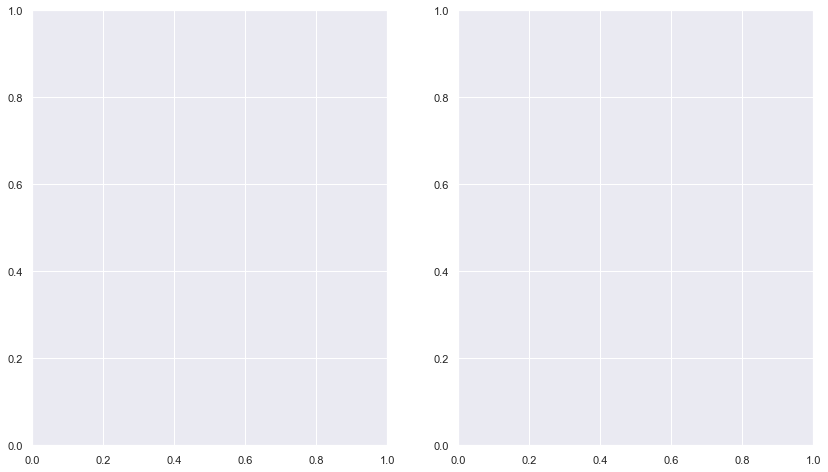

In [166]:
for i in columns:
    print(i)
    visualise_log_transform(resampled[i])